# Часть 1 Бустинг (5 баллов)

В этой части будем предсказывать зарплату data scientist-ов в зависимости  от ряда факторов с помощью градиентного бустинга.

В датасете есть следующие признаки:



* work_year: The number of years of work experience in the field of data science.

* experience_level: The level of experience, such as Junior, Senior, or Lead.

* employment_type: The type of employment, such as Full-time or Contract.

* job_title: The specific job title or role, such as Data Analyst or Data Scientist.

* salary: The salary amount for the given job.

* salary_currency: The currency in which the salary is denoted.

* salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

* employee_residence: The country or region where the employee resides.

* remote_ratio: The percentage of remote work offered in the job.

* company_location: The location of the company or organization.

* company_size: The company's size is categorized as Small, Medium, or Large.

In [107]:
import pandas as pd

df = pd.read_csv("ds_salaries.csv")
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## Задание 1 (0.5 балла) Подготовка



*   Разделите выборку на train, val, test (80%, 10%, 10%)
*   Выдерите salary_in_usd в качестве таргета
*   Найдите и удалите признак, из-за которого возможен лик в данных


In [108]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)
val, test = train_test_split(test, test_size=0.5)

X_train = train.drop("salary_in_usd", axis=1)
y_train = train["salary_in_usd"]

X_val = val.drop("salary_in_usd", axis=1)
y_val = val["salary_in_usd"]

X_test = test.drop("salary_in_usd", axis=1)
y_test = test["salary_in_usd"]

# salary - лик, так как напрямую связан с таргетом
X_train = X_train.drop("salary", axis=1)
X_val = X_val.drop("salary", axis=1)
X_test = X_test.drop("salary", axis=1)

X_test

,work_year,experience_level,employment_type,job_title,salary_currency,employee_residence,remote_ratio,company_location,company_size
360,2023,MI,FT,Big Data Engineer,EUR,ES,100,ES,M
3431,2022,SE,FT,Machine Learning Engineer,EUR,IE,100,IE,S
2517,2022,SE,FT,Data Engineer,USD,US,0,US,M
3538,2021,MI,CT,ML Engineer,USD,US,100,US,L
90,2023,SE,FT,Data Engineer,USD,US,0,US,M
...,...,...,...,...,...,...,...,...,...
512,2023,SE,FT,Data Engineer,USD,US,0,US,M
2344,2022,SE,FT,Data Scientist,USD,US,0,US,M
1922,2022,SE,FT,Data Engineer,USD,US,0,US,M
1463,2023,EN,FT,Data Analyst,USD,AR,100,US,S


## Задание 2 (0.5 балла) Линейная модель


*   Закодируйте категориальные  признаки с помощью OneHotEncoder
*   Обучите модель линейной регрессии
*   Оцените  качество через MAPE и RMSE


In [109]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import numpy as np

categorical_features = X_test.drop("work_year", axis=1).drop("remote_ratio", axis=1).columns
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_train_cat = encoder.fit_transform(X_train[categorical_features])
X_val_cat = encoder.transform(X_val[categorical_features])
X_test_cat = encoder.transform(X_test[categorical_features])

X_train = np.hstack([X_train_cat, X_train[['work_year', 'remote_ratio']].values])
X_val = np.hstack([X_val_cat, X_val[['work_year', 'remote_ratio']].values])
X_test = np.hstack([X_test_cat, X_test[['work_year', 'remote_ratio']].values])

model = LinearRegression()
model.fit(X_train, y_train)

pred = model.predict(X_test)

print('MAPE: ', (mean_absolute_percentage_error(y_test, pred) * 100).round(2))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, pred)).round(2))

MAPE:  4715001641.18
RMSE:  9501026795363.61


## Задание 3 (0.5 балла) XGboost

Начнем с библиотеки xgboost.

Обучите модель `XGBRegressor` на тех же данных, что линейную модель, подобрав оптимальные гиперпараметры (`max_depth, learning_rate, n_estimators, gamma`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [110]:
from xgboost.sklearn import XGBRegressor
import time

params = {
    'max_depth' : 5,
    'learning_rate' : 0.1,
    'n_estimators' : 200,
    'gamma' : 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'rmse'
}

model = XGBRegressor(**params)

start_time = time.time()
model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
train_time = time.time() - start_time

start_time = time.time()
pred = model.predict(X_test)
pred_time = time.time() - start_time

[0]	validation_0-rmse:59471.10615
[1]	validation_0-rmse:57703.92831
[2]	validation_0-rmse:56145.58036
[3]	validation_0-rmse:54856.26155
[4]	validation_0-rmse:53721.81152
[5]	validation_0-rmse:52780.73751
[6]	validation_0-rmse:52018.91548
[7]	validation_0-rmse:51525.75233
[8]	validation_0-rmse:51108.01804
[9]	validation_0-rmse:50663.50823
[10]	validation_0-rmse:50280.20173
[11]	validation_0-rmse:49976.52008
[12]	validation_0-rmse:49688.37584
[13]	validation_0-rmse:49451.08218
[14]	validation_0-rmse:49264.13675
[15]	validation_0-rmse:49098.48080
[16]	validation_0-rmse:48960.59549
[17]	validation_0-rmse:48881.55371
[18]	validation_0-rmse:48738.40518
[19]	validation_0-rmse:48678.37034
[20]	validation_0-rmse:48570.27326
[21]	validation_0-rmse:48547.83769
[22]	validation_0-rmse:48443.68270
[23]	validation_0-rmse:48387.33530
[24]	validation_0-rmse:48362.47837
[25]	validation_0-rmse:48237.30420
[26]	validation_0-rmse:48223.84673
[27]	validation_0-rmse:48234.53469
[28]	validation_0-rmse:48239.3

In [111]:
print('MAPE: ', mean_absolute_percentage_error(y_test, pred) * 100)
print('RMSE: ', np.sqrt(mean_squared_error(y_test, pred)))
print(train_time, pred_time)

MAPE:  36.223775527006346
RMSE:  49078.621755833396
0.32159876823425293 0.0010006427764892578


## Задание 4 (1 балл) CatBoost

Теперь библиотека CatBoost.

Обучите модель `CatBoostRegressor`, подобрав оптимальные гиперпараметры (`depth, learning_rate, iterations`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [112]:
from catboost import CatBoostRegressor

params = {
    'depth': 6,
    'learning_rate': 0.1,
    'iterations': 1000,
    'loss_function': 'RMSE',
}

model = CatBoostRegressor(**params)

start_time = time.time()
model.fit(X_train, y_train, eval_set=(X_val, y_val))
train_time = time.time() - start_time

start_pred = time.time()
pred = model.predict(X_test)
pred_time = time.time() - start_pred

0:	learn: 60780.5010174	test: 59504.4876057	best: 59504.4876057 (0)	total: 1.58ms	remaining: 1.58s
1:	learn: 59171.8442754	test: 58019.7968522	best: 58019.7968522 (1)	total: 3.08ms	remaining: 1.54s
2:	learn: 57485.4962247	test: 56391.2778387	best: 56391.2778387 (2)	total: 4.6ms	remaining: 1.53s
3:	learn: 56372.3698578	test: 55347.4902995	best: 55347.4902995 (3)	total: 6.05ms	remaining: 1.51s
4:	learn: 55258.7891255	test: 54362.6650636	best: 54362.6650636 (4)	total: 7.51ms	remaining: 1.49s
5:	learn: 54235.4449504	test: 53447.5029970	best: 53447.5029970 (5)	total: 8.98ms	remaining: 1.49s
6:	learn: 53448.5107035	test: 52730.6844074	best: 52730.6844074 (6)	total: 10.5ms	remaining: 1.49s
7:	learn: 52824.0729145	test: 52174.2907357	best: 52174.2907357 (7)	total: 12ms	remaining: 1.49s
8:	learn: 52323.1175235	test: 51644.8006875	best: 51644.8006875 (8)	total: 13.5ms	remaining: 1.49s
9:	learn: 51874.9197052	test: 51211.2575642	best: 51211.2575642 (9)	total: 15ms	remaining: 1.48s
10:	learn: 5141

In [113]:
print('MAPE: ', mean_absolute_percentage_error(y_test, pred) * 100)
print('RMSE: ', np.sqrt(mean_squared_error(y_test, pred)))
print(train_time, pred_time)

MAPE:  36.63144856172087
RMSE:  48198.24202648261
1.9688146114349365 0.024997711181640625


Для применения catboost моделей не обязательно сначала кодировать категориальные признаки, модель может кодировать их сама. Обучите catboost с подбором оптимальных гиперпараметров снова, используя pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметра cat_features. Оцените качество и время. Стало ли лучше?

In [114]:
from catboost import Pool

train, test = train_test_split(df, test_size=0.2)
val, test = train_test_split(test, test_size=0.5)

X_train = train.drop("salary_in_usd", axis=1)
y_train = train["salary_in_usd"]

X_val = val.drop("salary_in_usd", axis=1)
y_val = val["salary_in_usd"]

X_test = test.drop("salary_in_usd", axis=1)
y_test = test["salary_in_usd"]

# salary - лик, так как напрямую связан с таргетом
X_train = X_train.drop("salary", axis=1)
X_val = X_val.drop("salary", axis=1)
X_test = X_test.drop("salary", axis=1)

cat_features = ['experience_level', 'employment_type', 'job_title', 'salary_currency', 'employee_residence', 'company_location', 'company_size']

train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool = Pool(X_val, y_val, cat_features=cat_features)
test_pool = Pool(X_test, cat_features=cat_features)

params = {
    'depth': 6,
    'learning_rate': 0.1 ,
    'iterations': 1000,
    'loss_function': 'RMSE',
    'verbose': 100
} 

model = CatBoostRegressor()

start_time = time.time()
model.fit(train_pool, eval_set=val_pool)
train_time = time.time() - start_time

start_time = time.time()
pred = model.predict(X_test)
pred_time = time.time() - start_time

Learning rate set to 0.060519
0:	learn: 61481.0743548	test: 63588.6453548	best: 63588.6453548 (0)	total: 17ms	remaining: 17s
1:	learn: 60437.2872288	test: 62637.8663696	best: 62637.8663696 (1)	total: 33.7ms	remaining: 16.8s
2:	learn: 59558.9637305	test: 61847.3126148	best: 61847.3126148 (2)	total: 46.3ms	remaining: 15.4s
3:	learn: 58706.9009920	test: 61072.8714778	best: 61072.8714778 (3)	total: 68.8ms	remaining: 17.1s
4:	learn: 57963.0310344	test: 60421.6048932	best: 60421.6048932 (4)	total: 90.9ms	remaining: 18.1s
5:	learn: 57269.2188028	test: 59781.1830348	best: 59781.1830348 (5)	total: 104ms	remaining: 17.2s
6:	learn: 56621.7341565	test: 59190.2351862	best: 59190.2351862 (6)	total: 122ms	remaining: 17.3s
7:	learn: 56040.4370987	test: 58649.2559921	best: 58649.2559921 (7)	total: 142ms	remaining: 17.6s
8:	learn: 55509.9390720	test: 58164.3930094	best: 58164.3930094 (8)	total: 163ms	remaining: 18s
9:	learn: 55039.4711280	test: 57787.9309794	best: 57787.9309794 (9)	total: 186ms	remainin

In [115]:
print('MAPE: ', mean_absolute_percentage_error(y_test, pred) * 100)
print('RMSE: ', np.sqrt(mean_squared_error(y_test, pred)))
print(train_time, pred_time)

MAPE:  39.62052790254857
RMSE:  47275.52070687813
20.196313858032227 0.002999544143676758


**Ответ:** Такой способ показывает более хорошие результаты на выборке, однако кратно замедлеет процесс обучения и предсказания результатов

## Задание 5 (0.5 балла) LightGBM

И наконец библиотека LightGBM - используйте `LGBMRegressor`, снова подберите гиперпараметры, оцените качество и скорость.


In [116]:
from lightgbm import LGBMRegressor

for col in cat_features:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')
    X_test[col] = X_test[col].astype('category')

params = {
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'verbose': 10
}

model = LGBMRegressor(**params)

start_time = time.time()
model.fit(X_train, y_train, categorical_feature=cat_features, eval_set=[(X_val, y_val)], eval_metric='rmse')
train_time = time.time() - start_time

start_time = time.time()
pred = model.predict(X_test)
pred_time = time.time() - start_time

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.857324
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.543128
[LightGBM] [Debug] init for col-wise cost 0.000171 seconds, init for row-wise cost 0.001355 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 156
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 9
[LightGBM] [Info] Start training from score 137042.415779
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a 

In [117]:
print('MAPE: ', mean_absolute_percentage_error(y_test, pred) * 100)
print('RMSE: ', np.sqrt(mean_squared_error(y_test, pred)))
print(train_time, pred_time)

MAPE:  39.87408307021866
RMSE:  48572.47348382265
0.06399869918823242 0.007000923156738281


## Задание 6 (2 балла) Сравнение и выводы

Сравните модели бустинга и сделайте про них выводы, какая из моделей показала лучший/худший результат по качеству, скорости обучения и скорости предсказания? Как отличаются гиперпараметры для разных моделей?

**Ответ:** XGBoost показал лучшую точность и самое быстрое время предсказания, что делает его оптимальным выбором для задач с требованием к оперативности. При этом обучение заняло всего 0.32 сек.

CatBoost без Pool продемонстрировал лучший RMSE, но требовал больше времени на обучение. С Pool качество ухудшилось, но время обучения выросло до 20 сек.

LightGBM показал худшие метрики качества, но был самым быстрым в обучении.

Вывод: XGBoost демонстрирует наилучший баланс точности и скорости в данном тесте. CatBoost (особенно с Pool) может быть полезен при приоритете на RMSE, но требует существенно больше времени. LightGBM, несмотря на скорость, показал недостаточное качество для этих данных.

# Часть 2 Кластеризация (5 баллов)

Будем работать с данными о том, каких исполнителей слушают пользователи музыкального сервиса.

Каждая строка таблицы - информация об одном пользователе. Каждый столбец - это исполнитель (The Beatles, Radiohead, etc.)

Для каждой пары (пользователь, исполнитель) в таблице стоит число - доля прослушивания этого исполнителя этим пользователем.


In [31]:
import pandas as pd
ratings = pd.read_excel("https://github.com/evgpat/edu_stepik_rec_sys/blob/main/datasets/sample_matrix.xlsx?raw=true", engine='openpyxl')
ratings.head()

,user,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Будем строить кластеризацию исполнителей: если двух исполнителей слушало много людей примерно одинаковую долю своего времени (то есть векторы близки в пространстве), то, возможно исполнители похожи. Эта информация может быть полезна при построении рекомендательных систем.

## Задание 1 (0.5 балла) Подготовка

Транспонируем матрицу ratings, чтобы по строкам стояли исполнители.

In [34]:
ratings = ratings.T
ratings

,user,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,0.0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995.0,0.017884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4996,4996.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4997,4997.0,0.076923,NaN,NaN,NaN,NaN,NaN,0.002155,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4998,4998.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Выкиньте строку под названием `user`.

In [35]:
ratings = ratings.drop('user', axis=1)
ratings

,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,kanye west,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,0.012738,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.034483,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,0.095220,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.017884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4997,0.076923,NaN,NaN,NaN,NaN,NaN,0.002155,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)


Доля исполнителя в музыке, прослушанной  пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.



In [36]:
ratings = ratings.fillna(0)
ratings.sample()

,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,kanye west,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
2078,0.012346,0.014438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Задание 2 (0.5 балла) Первая кластеризация

Примените KMeans с 5ю кластерами, сохраните полученные лейблы

In [37]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(ratings.fillna(0).T)
labels = pd.Series(clusters, index=ratings.columns, name='cluster')
labels

C:\Users\prusakovR\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


the beatles           3
radiohead             2
deathcab for cutie    1
coldplay              1
modest mouse          1
                     ..
michal w. smith       1
群星                    1
agalloch              1
meshuggah             1
yellowcard            1
Name: cluster, Length: 1000, dtype: int32

Выведите размеры кластеров. Полезной ли получилась кластеризация? Почему KMeans может выдать такой результат?

In [38]:
cluster_sizes = labels.value_counts()
cluster_sizes

cluster
1    994
0      3
3      1
2      1
4      1
Name: count, dtype: int64

**Ответ:** Такая класстеризация бесполезна, так как 995 из 1000 объектов оказалось в 1 класстеере. Вероятнее всего из-за большого кол-ва нулей 1 класстер стягивает на себя все объекты.

## Задание 3 (0.5 балла) Объяснение результатов

При кластеризации получилось $\geq 1$ кластера размера 1. Выведите исполнителей, которые составляют такие кластеры. Среди них должна быть группа The Beatles.

In [39]:
artist_labels = pd.Series(kmeans.labels_, index=ratings.columns, name='cluster')
single_clusters = cluster_sizes[artist_labels.value_counts() == 1].index.tolist()
artists = artist_labels[artist_labels.isin(single_clusters)]
artists

the beatles    3
radiohead      2
enya           4
Name: cluster, dtype: int32

Изучите данные, почему именно The Beatles выделяется?

Подсказка: посмотрите на долю пользователей, которые слушают каждого исполнителя, среднюю долю прослушивания.

**Ответ:** The Beatles имеют сильно большие охваты чем другие исполнители в дата сете, высокая доля слушателей ставит битлз в отдельный класстер отдаленный от всех остальных пользователей, а Kmeans не позволяет удобно отделать подобные выбросы, поэтому битлз получают себе отдельный класстер

## Задание 4 (0.5 балла) Улучшение кластеризации

Попытаемся избавиться от этой проблемы: нормализуйте данные при помощи `normalize`.

In [41]:
from sklearn.preprocessing import normalize

ratings_normalized = normalize(ratings, norm='l1', axis=1)
ratings_normalized

array([[0.        , 0.02041695, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.18496241, 0.0245614 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.02863548, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.07692308, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.02789279, ..., 0.        , 0.        ,
        0.        ]])

Примените KMeans с 5ю кластерами на преобразованной матрице, посмотрите на их размеры. Стало ли лучше? Может ли кластеризация быть полезной теперь?

In [42]:
clusters = kmeans.fit_predict(ratings)
cluster_sizes = pd.Series(clusters).value_counts().sort_index()
cluster_sizes

0    1329
1    2023
2     182
3      99
4    1367
Name: count, dtype: int64

**Ответ** Теперь класстеризация гораздо полезнее, так как Kmeans лучше выделил ключевые признаки и поделил датасет на класстеры нормального размера, теперь эти данные можно использовать для анализа

## Задание 5 (1 балл) Центроиды

Выведите для каждого кластера названия топ-10 исполнителей, ближайших к центроиду по косинусной мере. Проинтерпретируйте результат. Что можно сказать о смысле кластеров?

In [108]:
from scipy.spatial.distance import cosine
import numpy as np
import pandas as pd

ratings_filled = ratings.fillna(0).T
artist_names = ratings_filled.index
ratings_normalized = normalize(ratings_filled, axis=1)

results = {}
for cluster_id in range(5):    
    cluster_data = ratings_normalized[(clusters == cluster_id)]
    current_artists = artist_names[(clusters == cluster_id)]
    
    distances = [1 - np.dot(artist_vec, kmeans.cluster_centers_[cluster_id]) for artist_vec in cluster_data]
    
    top10_idx = np.argsort(distances)[:10]
    results[cluster_id] = current_artists[top10_idx]

results

{0: Index(['nas', 'jay-z', 'kanye west', 'lupe the gorilla',
        'a tribe called quest', 'the roots featuring d'angelo', 'gangstarr',
        'little brother', 'lil' wayne', 'murs and 9th wonder'],
       dtype='object'),
 1: Index(['fall out boy', 'the all-americian rejects', 'paramore',
        'kelly clarkson', 'john mayer', 'the fray', 'maroon5',
        'dashboard confesssional', 'somethings corporate', 'coldplay'],
       dtype='object'),
 2: Index(['brand new', 'blink-182', 'alkaline trio', 'against me!', 'underoath',
        'descendents', 'new found glory', 'less than jake', 'thrice',
        'chiodos'],
       dtype='object'),
 3: Index(['the beatles', 'the rolling stones', 'dylan. bob', 'who',
        'led zeppelin.', 'miles davis.', 'simon and garfunkel', 'young, neil',
        'pink fluid', 'velvet underground'],
       dtype='object'),
 4: Index(['radiohead', 'the arcade fire', 'the shins', 'sufjan stevens',
        'belle and sebastian', 'broken social scene', 'the p

**Ответ:** Такая класстеризация очень круто работает, если почитать про эти группы, то становится видно, что класстеры объединяют между собой схожие по стилю или по времени активности исполнители. Эта класстеризация позволяет использовать класстеры в бизнес целях

## Задание 6 (1 балл) Визуализация

Хотелось бы как-то визуализировать полученную кластеризацию. Постройте точечные графики `plt.scatter` для нескольких пар признаков исполнителей, покрасив точки в цвета кластеров. Почему визуализации получились такими? Хорошо ли они отражают разделение на кластеры? Почему?

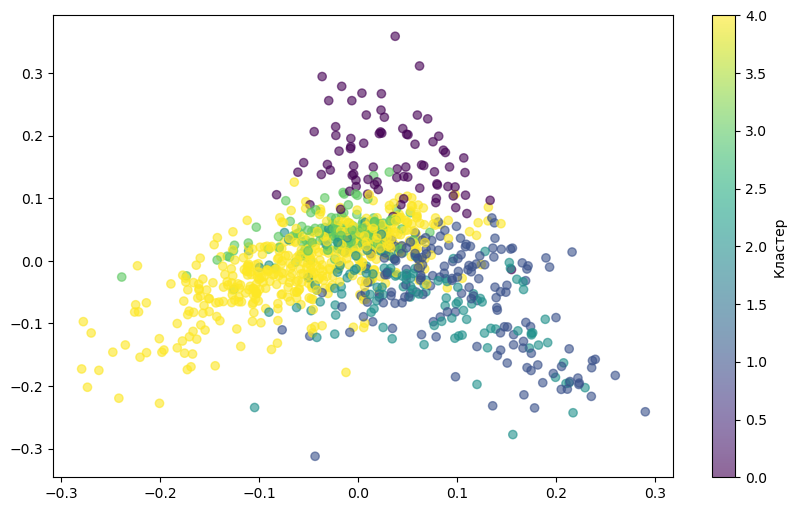

In [111]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
points = pca.fit_transform(ratings_normalized)

plt.figure(figsize=(10,6))
plt.scatter(points[:,0], points[:,1], c=clusters, cmap='viridis', alpha=0.6)
plt.colorbar(label='Кластер')
plt.show()

**Ответ:** Класстеры делят данные неплохо, но видно, что по середине они сильно перемешиваются, что не позволяет хорошо разделить точки. Однако надо помнить, что это класстеризация музыки, которую в целом очень сложно разделить на логические группы, поэтому можно сказать, что данная класстеризация работает неплохо, но всё же остаются проблемы выбросов, которые можно решить только изменением алгоритма класстеризации

Для визуализации данных высокой размерности существует метод t-SNE (стохастическое вложение соседей с t-распределением). Данный метод является нелинейным методом снижения размерности: каждый объект высокой размерности будет моделироваться объектов более низкой (например, 2) размерности таким образом, чтобы похожие объекты моделировались близкими, непохожие - далекими с большой вероятностью.

Примените `TSNE` из библиотеки `sklearn` и визуализируйте полученные объекты, покрасив их в цвета их кластеров

C:\Users\prusakovR\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


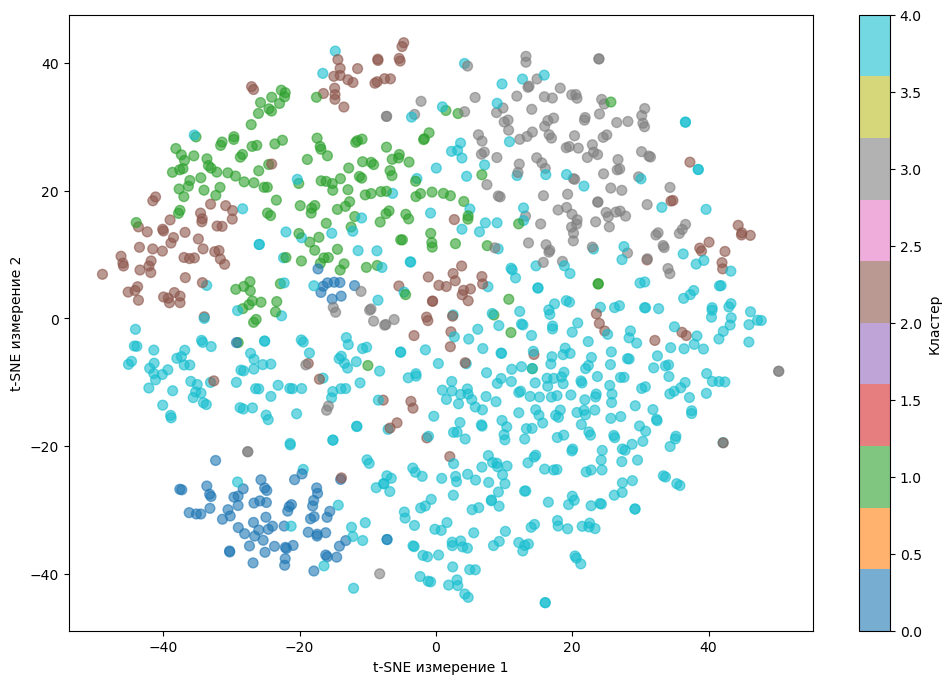

In [114]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(ratings_normalized)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clusters, cmap='tab10', alpha=0.6, s=50)

plt.colorbar(scatter, label='Кластер')
plt.xlabel('t-SNE измерение 1')
plt.ylabel('t-SNE измерение 2')

plt.show()

## Задание 7 (1 балл) Подбор гиперпараметров

Подберите оптимальное количество кластеров (максимум 100 кластеров) с использованием индекса Силуэта. Зафиксируйте `random_state=42`

In [115]:
from sklearn.metrics import silhouette_score

cluster_range = range(2, 101)
silhouette_scores = []

random_state = 42
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    cluster_labels = kmeans.fit_predict(ratings_normalized)
    
    silhouette_avg = silhouette_score(ratings_normalized, cluster_labels)
    silhouette_scores.append(silhouette_avg)

optimal_clusters = cluster_range[np.argmax(silhouette_scores)]
optimal_clusters

C:\Users\prusakovR\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\prusakovR\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\prusakovR\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\prusakovR\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memor

98

Выведите исполнителей, ближайших с центроидам (аналогично заданию 5). Как соотносятся результаты? Остался ли смысл кластеров прежним? Расскажите про смысл 1-2 интересных кластеров, если он изменился и кластеров слишком много, чтобы рассказать про все.

In [121]:
optimal_kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
optimal_labels = optimal_kmeans.fit_predict(ratings_normalized)

for cluster_id in [0, 55]:
    cluster_data = ratings_normalized[(optimal_labels == cluster_id)]
    cluster_artists = ratings_filled.index[(optimal_labels == cluster_id)]
    
    distances = [cosine(artist_vec, optimal_kmeans.cluster_centers_[cluster_id]) for artist_vec in cluster_data]
    
    print(f"\nКластер {cluster_id} (топ-5 исполнителей):")
    print(cluster_artists)

C:\Users\prusakovR\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(



Кластер 0 (топ-5 исполнителей):
Index(['the faint', 'dr. dre', 'the bloodhound gang', 'violent femmes', 'owen',
       'margot and the nuclear so and sos'],
      dtype='object')

Кластер 55 (топ-5 исполнителей):
Index(['the ting tings', 'sia', 'she & him', 'kate nash', 'lykke li', 'adele',
       'the sounds'],
      dtype='object')


**Ответ:** Кластеризация успешно разделила исполнителей по музыкальным стилям и аудитории: четко выделились основные жанры (рок, поп, хип-хоп), а также нишевые направления. Результаты отражают реальные музыкальные предпочтения пользователей, хотя границы между некоторыми жанрами остаются размытыми из-за кросс-жанровых влияний.

Сделайте t-SNE визуализацию полученной кластеризации.

C:\Users\prusakovR\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


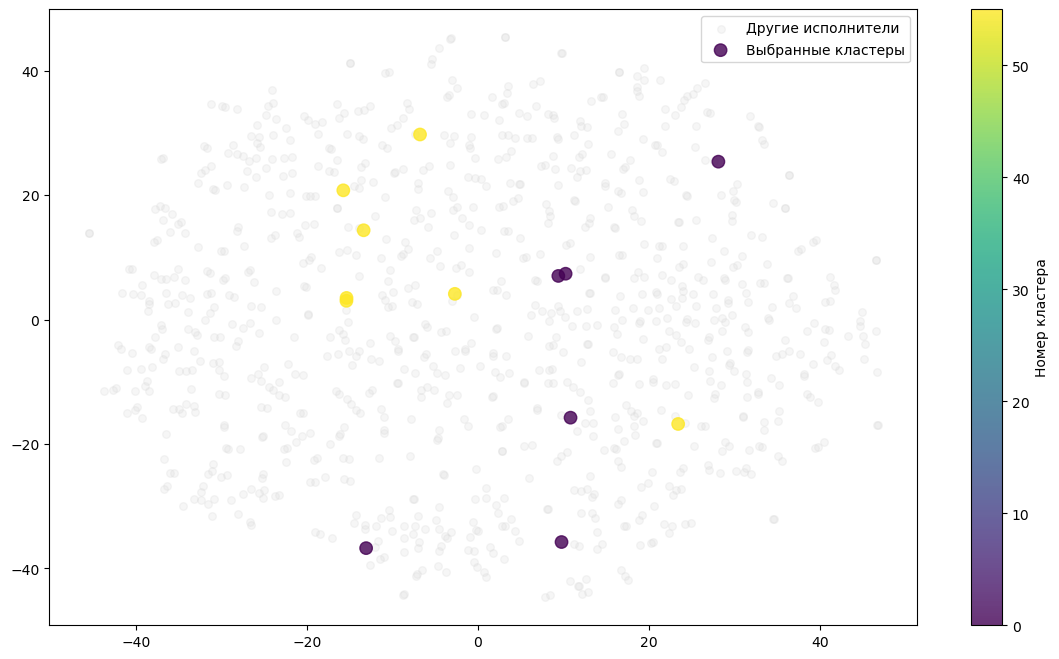

In [126]:
from sklearn.manifold import TSNE

interesting_clusters = [0, 55]
highlight_mask = np.isin(optimal_labels, interesting_clusters)

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(ratings_normalized)

plt.figure(figsize=(14, 8))
plt.scatter(tsne_results[~highlight_mask, 0], tsne_results[~highlight_mask, 1], c='lightgray', alpha=0.2, s=30, label='Другие исполнители')

scatter = plt.scatter(tsne_results[highlight_mask, 0], tsne_results[highlight_mask, 1], c=optimal_labels[highlight_mask], cmap='viridis', alpha=0.8, s=80, label='Выбранные кластеры')

plt.colorbar(scatter, label='Номер кластера')
plt.legend()
plt.show()

Если кластеров получилось слишком много и визуально цвета плохо отличаются, покрасьте только какой-нибудь интересный кластер из задания выше (`c = (labels == i)`). Хорошо ли этот кластер отражается в визуализации?

**Ответ:** Такая класстеризация работает не очень хорошо, видимо 98 класстеров - слишком много для выделения на двухмерной плоскости и визуально они выглядят далекими, хотя по стилям музыкантов - очень похожи